In [0]:
dbutils.widgets.removeAll()
dbutils.widgets.text("patient_id", "", "Patient ID")
dbutils.widgets.dropdown("order", "Newest", ["Newest", "Oldest"], "Sort Order")
dbutils.widgets.text("page", "1", "Page Number")
dbutils.widgets.text("page_size", "20", "Page Size")
dbutils.widgets.dropdown("mpr", "ALL", ["SAG", "TRA", "COR", "ALL"], "MPR")
dbutils.widgets.dropdown("patient_position", "ALL", ["HFS", "FFS", "ALL"], "Patient Position")
dbutils.widgets.text("body_part", "", "Body Part")

In [0]:
%pip install nibabel
%pip install pydicom matplotlib
dbutils.library.restartPython()

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


,mpr,body_part,patient_position,image,image_id,series_id,study_id,patient_id,date,time,path
0,SAG,LSPINE,HFS,,1.3.6.1.4.1.9590.100.1.2.322768266212771398405429193220217484272,1.3.12.2.1107.5.2.40.50233.2016030909181239634304374.0.0.0,1.3.12.2.1107.5.2.40.50233.30000016030907083527900000007,1,2016-03-09,91815290,/Volumes/dbms/bronze/lumbar-spine-dataset/MRI-data/0001/L-SPINE_LSS_20160309_091629_240000/LOCALIZER_0001/LOCALIZER_0_0001_002.ima
1,SAG,LSPINE,HFS,,1.3.6.1.4.1.9590.100.1.2.161730626213679991813193325211727548849,1.3.12.2.1107.5.2.40.50233.2016030909181239634304374.0.0.0,1.3.12.2.1107.5.2.40.50233.30000016030907083527900000007,1,2016-03-09,91819155,/Volumes/dbms/bronze/lumbar-spine-dataset/MRI-data/0001/L-SPINE_LSS_20160309_091629_240000/LOCALIZER_0001/LOCALIZER_0_0001_004.ima
2,SAG,LSPINE,HFS,,1.3.6.1.4.1.9590.100.1.2.132924266112714677607850162371570423747,1.3.12.2.1107.5.2.40.50233.2016030909181239634304374.0.0.0,1.3.12.2.1107.5.2.40.50233.30000016030907083527900000007,1,2016-03-09,91823020,/Volumes/dbms/bronze/lumbar-spine-dataset/MRI-data/0001/L-SPINE_LSS_20160309_091629_240000/LOCALIZER_0001/LOCALIZER_0_0001_006.ima
3,SAG,LSPINE,HFS,,1.3.6.1.4.1.9590.100.1.2.176246553213793482007050154551904030973,1.3.12.2.1107.5.2.40.50233.2016030909181239634304374.0.0.0,1.3.12.2.1107.5.2.40.50233.30000016030907083527900000007,1,2016-03-09,91826882,/Volumes/dbms/bronze/lumbar-spine-dataset/MRI-data/0001/L-SPINE_LSS_20160309_091629_240000/LOCALIZER_0001/LOCALIZER_0_0001_008.ima
4,SAG,LSPINE,HFS,,1.3.6.1.4.1.9590.100.1.2.338294907212092058724332148592124191472,1.3.12.2.1107.5.2.40.50233.2016030909181239634304374.0.0.0,1.3.12.2.1107.5.2.40.50233.30000016030907083527900000007,1,2016-03-09,91830747,/Volumes/dbms/bronze/lumbar-spine-dataset/MRI-data/0001/L-SPINE_LSS_20160309_091629_240000/LOCALIZER_0001/LOCALIZER_0_0001_001.ima
5,SAG,LSPINE,HFS,,1.3.6.1.4.1.9590.100.1.2.48090362812882453817021817681548572051,1.3.12.2.1107.5.2.40.50233.2016030909181239634304374.0.0.0,1.3.12.2.1107.5.2.40.50233.30000016030907083527900000007,1,2016-03-09,91834610,/Volumes/dbms/bronze/lumbar-spine-dataset/MRI-data/0001/L-SPINE_LSS_20160309_091629_240000/LOCALIZER_0001/LOCALIZER_0_0001_003.ima
6,SAG,LSPINE,HFS,,1.3.6.1.4.1.9590.100.1.2.88529505311045987626462739573649439543,1.3.12.2.1107.5.2.40.50233.2016030909181239634304374.0.0.0,1.3.12.2.1107.5.2.40.50233.30000016030907083527900000007,1,2016-03-09,91838475,/Volumes/dbms/bronze/lumbar-spine-dataset/MRI-data/0001/L-SPINE_LSS_20160309_091629_240000/LOCALIZER_0001/LOCALIZER_0_0001_005.ima
7,COR,LSPINE,HFS,,1.3.6.1.4.1.9590.100.1.2.143456035811384306642548673623592275008,1.3.12.2.1107.5.2.40.50233.30000016030907235840700000011,1.3.12.2.1107.5.2.40.50233.30000016030907083527900000007,1,2016-03-09,91838475,/Volumes/dbms/bronze/lumbar-spine-dataset/MRI-data/0001/L-SPINE_LSS_20160309_091629_240000/POSDISP_[4]_T2_TSE_TRA_384_5001/POSDISP_[4]_0001_001.ima
8,SAG,LSPINE,HFS,,1.3.6.1.4.1.9590.100.1.2.339490774111422745035396186970533818140,1.3.12.2.1107.5.2.40.50233.2016030909181239634304374.0.0.0,1.3.12.2.1107.5.2.40.50233.30000016030907083527900000007,1,2016-03-09,91842340,/Volumes/dbms/bronze/lumbar-spine-dataset/MRI-data/0001/L-SPINE_LSS_20160309_091629_240000/LOCALIZER_0001/LOCALIZER_0_0001_007.ima
9,COR,LSPINE,HFS,,1.3.6.1.4.1.9590.100.1.2.84950320613059960034042006143047519430,1.3.12.2.1107.5.2.40.50233.30000016030907235840700000011,1.3.12.2.1107.5.2.40.50233.30000016030907083527900000007,1,2016-03-09,91842340,/Volumes/dbms/bronze/lumbar-spine-dataset/MRI-data/0001/L-SPINE_LSS_20160309_091629_240000/POSDISP_[4]_T2_TSE_TRA_384_5001/POSDISP_[4]_0001_003.ima

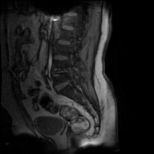
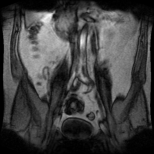
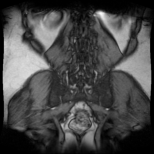
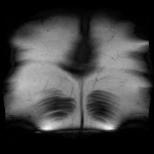
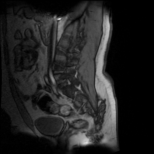
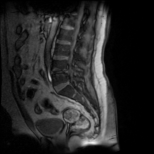
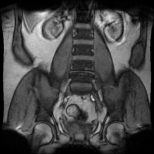
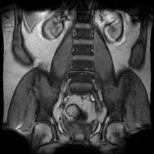
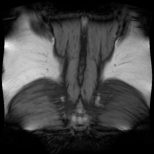
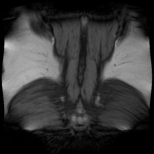

In [0]:
import pydicom
import matplotlib.pyplot as plt

patient_id = dbutils.widgets.get("patient_id")
order = dbutils.widgets.get("order")
page = int(dbutils.widgets.get("page"))
page_size = int(dbutils.widgets.get("page_size"))
mpr = dbutils.widgets.get("mpr")
patient_position = dbutils.widgets.get("patient_position")
body_part = dbutils.widgets.get("body_part")
offset = (page - 1) * page_size

where_clauses = [f"f.patient_id = '{patient_id}'"]

if mpr != "ALL":
    where_clauses.append(f"se.mpr = '{mpr}'")
if patient_position != "ALL":
    where_clauses.append(f"s.patient_position = '{patient_position}'")
if body_part.strip():
    where_clauses.append(f"se.body_part = '{body_part}'")

where_sql = " AND ".join(where_clauses)

query = f"""
SELECT 
  f.*, 
  s.study_date AS date, 
  i.image_time AS time, 
  i.path,
  se.mpr,
  s.patient_position,
  se.body_part AS body_part
FROM dbms.gold.fact_img f
LEFT JOIN dbms.gold.dim_study s ON f.study_id = s.uid
LEFT JOIN dbms.gold.dim_image i ON f.image_id = i.sop_instance_uid
LEFT JOIN dbms.gold.dim_series se ON f.series_id = se.uid
WHERE {where_sql}
ORDER BY s.study_date {'DESC' if order == 'Newest' else 'ASC'}, i.image_time {'DESC' if order == 'Newest' else 'ASC'}
LIMIT {page_size} OFFSET {offset}
"""

df = spark.sql(query)

# Collect all rows as dicts
rows = df.collect()

# Prepare data for display: add image as base64-encoded PNG
import io
import base64

def dicom_to_base64_png(path):
    try:
        ds = pydicom.dcmread(path)
        fig, ax = plt.subplots(figsize=(2,2))
        ax.imshow(ds.pixel_array, cmap=plt.cm.gray)
        ax.axis('off')
        buf = io.BytesIO()
        plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
        plt.close(fig)
        buf.seek(0)
        img_base64 = base64.b64encode(buf.read()).decode('utf-8')
        return f'<img src="data:image/png;base64,{img_base64}" width="128"/>'
    except Exception:
        return ''

display_rows = []
for row in rows:
    row_dict = row.asDict()
    path = row_dict.get('path')
    row_dict['image'] = dicom_to_base64_png(path) if path else ''
    # Ensure mpr, body_part, and patient_position are present for display
    row_dict['mpr'] = row_dict.get('mpr', '')
    row_dict['body_part'] = row_dict.get('body_part', '')
    row_dict['patient_position'] = row_dict.get('patient_position', '')
    display_rows.append(row_dict)

import pandas as pd
pd_df = pd.DataFrame(display_rows)

# Display as HTML so images render, and show mpr, body_part, and patient_position columns
from IPython.display import display as ipy_display, HTML
columns_to_display = ['mpr', 'body_part', 'patient_position', 'image'] + [col for col in pd_df.columns if col not in ['mpr', 'body_part', 'patient_position', 'image']]
if not pd_df.empty:
    ipy_display(HTML(pd_df[columns_to_display].to_html(escape=False)))
else:
    ipy_display(HTML("<b>No results found.</b>"))